In [ ]:
# Install necessary packages (these installations will be required after every new session)
!pip install --upgrade pip
!pip install boto3 s3fs

# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import boto3
from google.colab import userdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py)

Reading Data

In [ ]:
# Set up AWS credentials (consider using IAM roles or environment variables for security)
aws_access_key_id = userdata.get('AWS_ACCESS_KEY')
aws_secret_access_key = userdata.get('AWS_SECRET_ACCESS_KEY')
region_name = 'us-west-1'

# Initialize an S3 client
s3 = boto3.client('s3',
                  aws_access_key_id=aws_access_key_id,
                  aws_secret_access_key=aws_secret_access_key,
                  region_name=region_name)

# Alternatively, use pandas with s3fs directly to read a CSV file
bucket_name = 'movielens32mil'
movies_file_key = 'movies.csv'
ratings_file_key = 'ratings.csv'
tags_file_key = 'tags.csv'
links_file_key = 'links.csv'

# Read CSV files directly from S3
movies = pd.read_csv(f's3://{bucket_name}/{movies_file_key}')
ratings = pd.read_csv(f's3://{bucket_name}/{ratings_file_key}')
tags = pd.read_csv(f's3://{bucket_name}/{tags_file_key}')
links = pd.read_csv(f's3://{bucket_name}/{links_file_key}')

print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)
print("Tags shape:", tags.shape)
print("Links shape:", links.shape)

/usr/local/lib/python3.11/dist-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Movies shape: (87585, 3)
Ratings shape: (32000204, 4)
Tags shape: (2000072, 4)
Links shape: (87585, 3)


Optimize Data Types (Including Timestamp)

In [ ]:
import pandas as pd

# Check memory usage before optimization
print("Memory usage BEFORE optimizing data types:")
print(ratings.info(memory_usage="deep"))

import numpy as np

# Convert userId and movieId to int32, rating to float32
ratings['userId'] = ratings['userId'].astype(np.int32)
ratings['movieId'] = ratings['movieId'].astype(np.int32)
ratings['rating'] = ratings['rating'].astype(np.float32)

# Convert timestamp to datetime format
if 'timestamp' in ratings.columns:
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Check memory usage after optimization
print("\nMemory usage AFTER optimizing data types:")
print(ratings.info(memory_usage="deep"))

Memory usage BEFORE optimizing data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None

Memory usage AFTER optimizing data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int32         
 1   movieId    int32         
 2   rating     float32       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 610.4 MB
None


Overview

In [ ]:
# Overview and Basic Inspection of the Data

# Display first few rows of each dataset
print("Movies:")
display(movies.head())

print("Ratings:")
display(ratings.head())

print("Tags:")
display(tags.head())

print("Links:")
display(links.head())

Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,17,4.0,1999-12-03 19:24:37
1,1,25,1.0,1999-12-03 19:43:48
2,1,29,2.0,1999-11-22 00:36:16
3,1,30,5.0,1999-12-03 19:24:37
4,1,32,5.0,1999-11-22 00:00:58


Tags:


,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


Links:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
# Feature Summary: Check Data Types and Potential Inconsistencies
print("Movies Info:")
print(movies.info())

print("\nRatings Info:")
print(ratings.info())

print("\nTags Info:")
print(tags.info())

print("\nLinks Info:")
print(links.info())

Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int32         
 1   movieId    int32         
 2   rating     float32       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int32(2)
memory usage: 610.4 MB
None

Tags Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   time

Missing Values

In [ ]:
# Check for missing values
print("Missing values in Movies:")
print(movies.isnull().sum())
print("\nMissing values in Ratings:")
print(ratings.isnull().sum())
print("\nMissing values in Tags:")
print(tags.isnull().sum())
print("\nMissing values in Links:")
print(links.isnull().sum())

Missing values in Movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Tags:
userId        0
movieId       0
tag          17
timestamp     0
dtype: int64

Missing values in Links:
movieId      0
imdbId       0
tmdbId     124
dtype: int64


Duplicate Values

In [ ]:
# Checking for duplicate rows in each dataset
print("\nChecking for duplicate rows:")
print("Movies duplicates:", movies.duplicated().sum())
print("Ratings duplicates:", ratings.duplicated().sum())
print("Tags duplicates:", tags.duplicated().sum())
print("Links duplicates:", links.duplicated().sum())

# Dropping duplicates (if any)
movies = movies.drop_duplicates()
ratings = ratings.drop_duplicates()
tags = tags.drop_duplicates()
links = links.drop_duplicates()

print("\nDuplicates removed (if any).")


Checking for duplicate rows:
Movies duplicates: 0
Ratings duplicates: 0
Tags duplicates: 0
Links duplicates: 0

Duplicates removed (if any).


Unique Values Check

In [ ]:
# Unique values check
print("\nUnique Movie IDs in Movies dataset:", movies['movieId'].nunique())
print("Unique Movie IDs in Ratings dataset:", ratings['movieId'].nunique())
print("Unique User IDs in Ratings dataset:", ratings['userId'].nunique())
print("Unique Movie IDs in Tags dataset:", tags['movieId'].nunique())
print("Unique Movie IDs in Links dataset:", links['movieId'].nunique())


Unique Movie IDs in Movies dataset: 87585
Unique Movie IDs in Ratings dataset: 84432
Unique User IDs in Ratings dataset: 200948
Unique Movie IDs in Tags dataset: 51323
Unique Movie IDs in Links dataset: 87585


Summary Statistics

In [ ]:
# Summary statistics for numerical columns
print("Movies Dataset Summary:")
display(movies.describe())

print("\nRatings Dataset Summary:")
display(ratings.describe())

print("\nTags Dataset Summary:")
display(tags.describe())

print("\nLinks Dataset Summary:")
display(links.describe())

Movies Dataset Summary:


,movieId
count,87585.000000
mean,157651.365519
std,79013.402099
min,1.000000
25%,112657.000000
50%,165741.000000
75%,213203.000000
max,292757.000000



Ratings Dataset Summary:


,userId,movieId,rating,timestamp
count,3.200020e+07,3.200020e+07,3.200020e+07,32000204
mean,1.002785e+05,2.931861e+04,3.540396e+00,2010-05-30 17:39:59.573265152
min,1.000000e+00,1.000000e+00,5.000000e-01,1995-01-09 11:46:44
25%,5.005300e+04,1.233000e+03,3.000000e+00,2003-04-22 11:53:50
50%,1.002970e+05,3.452000e+03,3.500000e+00,2010-04-30 10:03:32.500000
75%,1.504510e+05,4.419900e+04,4.000000e+00,2017-08-19 15:59:05.249999872
max,2.009480e+05,2.927570e+05,5.000000e+00,2023-10-13 02:29:07
std,5.794905e+04,5.095816e+04,1.086124e+00,NaN



Tags Dataset Summary:


,userId,movieId,timestamp
count,2.000072e+06,2.000072e+06,2.000072e+06
mean,8.192859e+04,7.189326e+04,1.528914e+09
std,3.810650e+04,7.480379e+04,1.290835e+08
min,2.200000e+01,1.000000e+00,1.135429e+09
25%,6.841300e+04,4.011000e+03,1.473615e+09
50%,7.821300e+04,5.232800e+04,1.574071e+09
75%,1.036980e+05,1.222940e+05,1.614740e+09
max,1.622790e+05,2.926290e+05,1.697155e+09



Links Dataset Summary:


,movieId,imdbId,tmdbId
count,87585.000000,8.758500e+04,8.746100e+04
mean,157651.365519,2.792840e+06,2.413823e+05
std,79013.402099,4.278866e+06,2.471467e+05
min,1.000000,1.000000e+00,2.000000e+00
25%,112657.000000,9.464200e+04,4.683600e+04
50%,165741.000000,4.929960e+05,1.392720e+05
75%,213203.000000,3.877296e+06,3.816930e+05
max,292757.000000,2.908110e+07,1.186337e+06


Top 10 Movies with Most Ratings

<ipython-input-10-6e59d1874e4c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_movies_df["title"], x=top_movies_df["num_ratings"], palette="viridis")


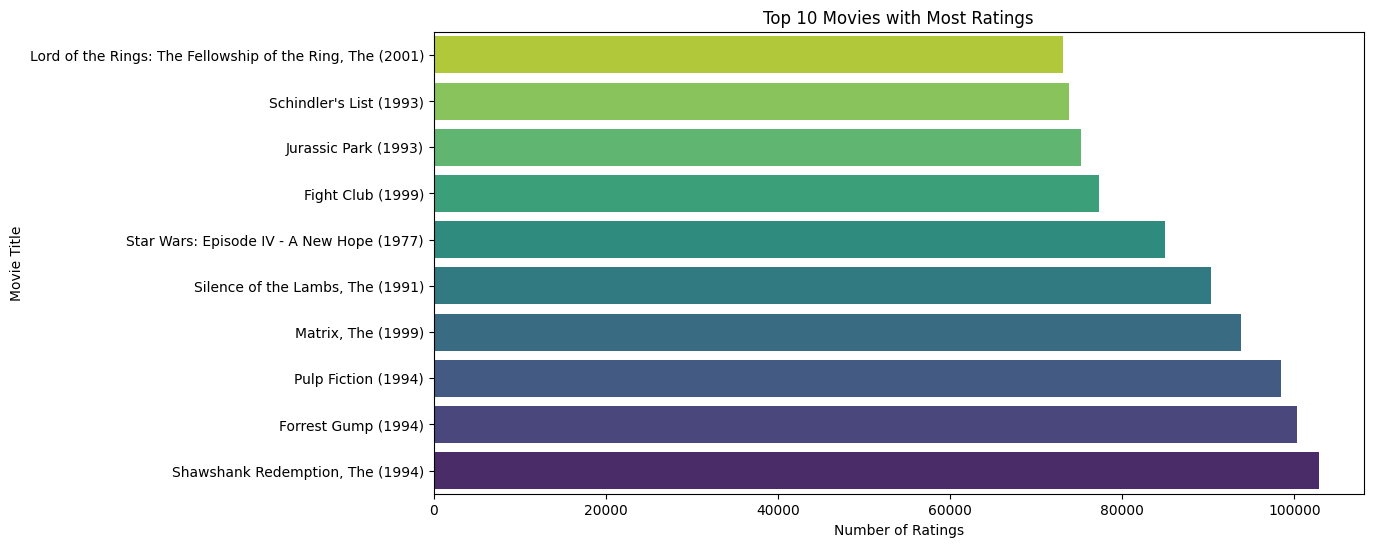

In [ ]:
# Get the top 10 movies with the most ratings
top_movies = ratings['movieId'].value_counts().head(10)

# Merge with movie titles
top_movies_df = movies[movies['movieId'].isin(top_movies.index)]
top_movies_df = top_movies_df.set_index("movieId").loc[top_movies.index]
top_movies_df["num_ratings"] = top_movies.values

# Plot
plt.figure(figsize=(12,6))
sns.barplot(y=top_movies_df["title"], x=top_movies_df["num_ratings"], palette="viridis")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Movies with Most Ratings")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Top 10 Users with Most Reviews

<ipython-input-11-457b4181af96>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users_df["userId"], y=top_users_df["num_ratings"], palette="magma")


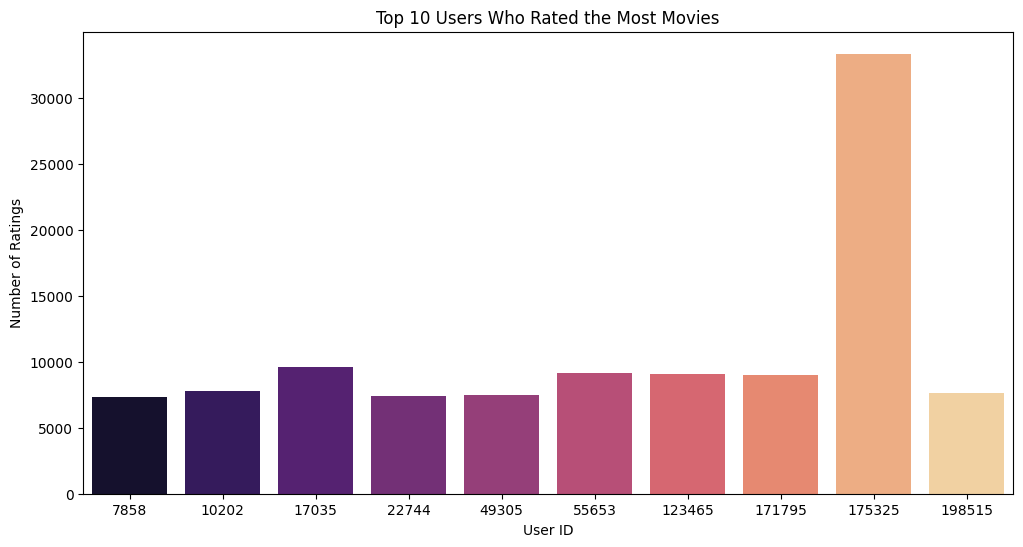

In [ ]:
# Get the top 10 users who have rated the most movies
top_users = ratings['userId'].value_counts().head(10)

# Convert to DataFrame for visualization
top_users_df = pd.DataFrame({"userId": top_users.index, "num_ratings": top_users.values})

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=top_users_df["userId"], y=top_users_df["num_ratings"], palette="magma")
plt.ylabel("Number of Ratings")
plt.xlabel("User ID")
plt.title("Top 10 Users Who Rated the Most Movies")
plt.gca()
plt.show()

Investigating User 175325 for potential behavior

<ipython-input-12-5543273e143c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_175325_ratings['timestamp'] = pd.to_datetime(user_175325_ratings['timestamp'], unit='s')
<ipython-input-12-5543273e143c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  user_175325_ratings.resample('M').count()['rating'].plot()


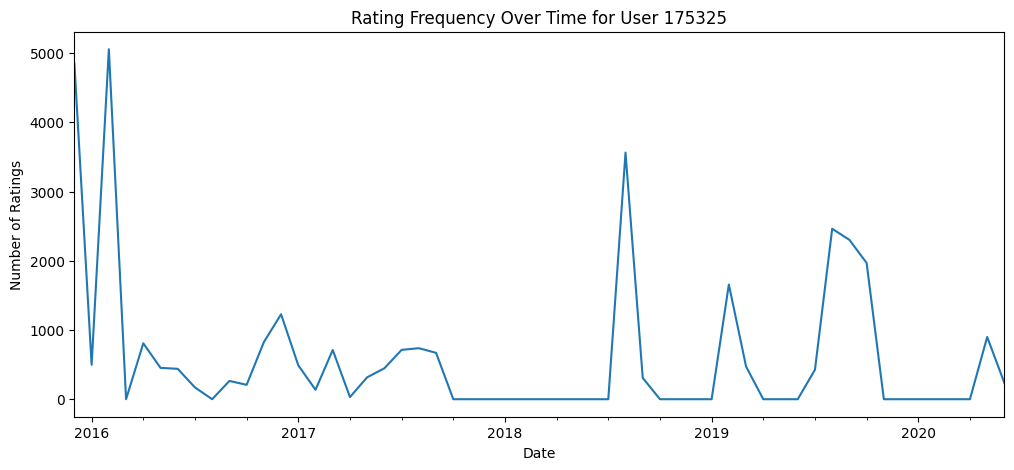

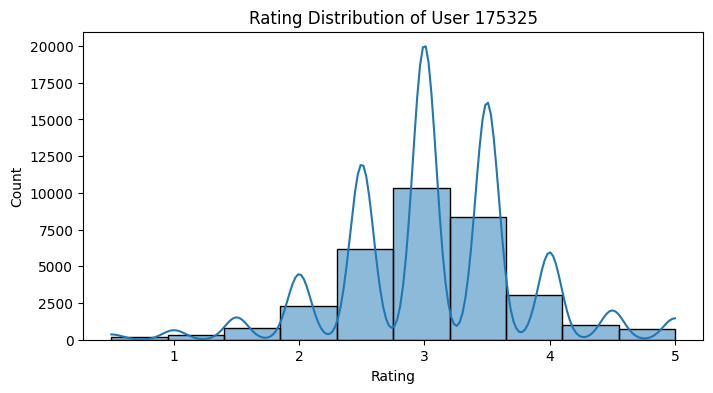

User 175325 has rated 33332 unique movies.

Percentage of each rating given by User 175325:
rating
3.0    31.078243
3.5    25.039002
2.5    18.495740
4.0     9.210368
2.0     6.912276
4.5     3.087123
1.5     2.355094
5.0     2.259090
1.0     1.005040
0.5     0.558022
Name: proportion, dtype: float64


In [ ]:
# Filter ratings for user 175325
user_175325_ratings = ratings[ratings['userId'] == 175325]

# Check rating frequency over time (if timestamp is available)
if 'timestamp' in ratings.columns:
    user_175325_ratings['timestamp'] = pd.to_datetime(user_175325_ratings['timestamp'], unit='s')
    user_175325_ratings.set_index('timestamp', inplace=True)

    plt.figure(figsize=(12, 5))
    user_175325_ratings.resample('M').count()['rating'].plot()
    plt.xlabel("Date")
    plt.ylabel("Number of Ratings")
    plt.title("Rating Frequency Over Time for User 175325")
    plt.show()

# Check rating distribution
plt.figure(figsize=(8, 4))
sns.histplot(user_175325_ratings['rating'], bins=10, kde=True)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution of User 175325")
plt.show()

# Check how many unique movies this user rated
unique_movies_rated = user_175325_ratings['movieId'].nunique()
print(f"User 175325 has rated {unique_movies_rated} unique movies.")

# Check if the user gives mostly the same rating (potential bot behavior)
rating_counts = user_175325_ratings['rating'].value_counts(normalize=True) * 100
print("\nPercentage of each rating given by User 175325:")
print(rating_counts)

Removing User 175325 to avoid bias/skew

In [ ]:
# Remove User 175325 from the ratings dataset
ratings = ratings[ratings['userId'] != 175325]

# Confirm removal
print(f"User 175325 removed. New dataset shape: {ratings.shape}")
print(f"Unique users after removal: {ratings['userId'].nunique()}")

User 175325 removed. New dataset shape: (31966872, 4)
Unique users after removal: 200947


Ratings Distribution

<ipython-input-14-1925238f25f4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


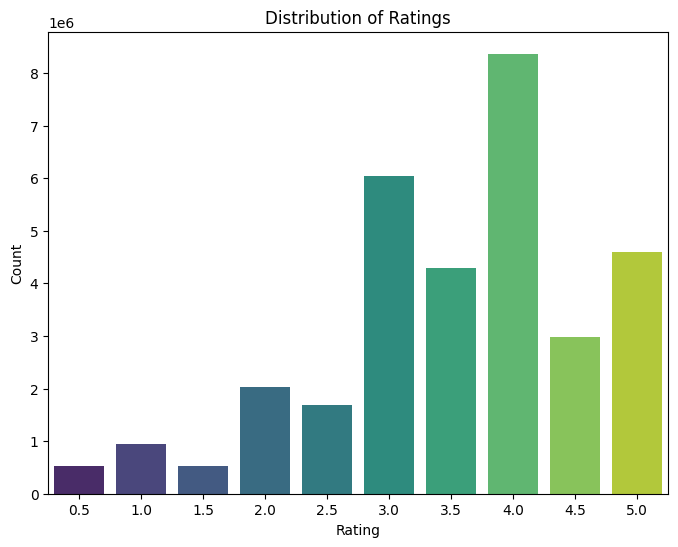

In [ ]:
# Ratings Distribution Analysis

plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Movie-Genre Analysis

<ipython-input-15-4802ed4b63c1>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=genre_avg_ratings.index, x=genre_avg_ratings.values, palette="coolwarm")


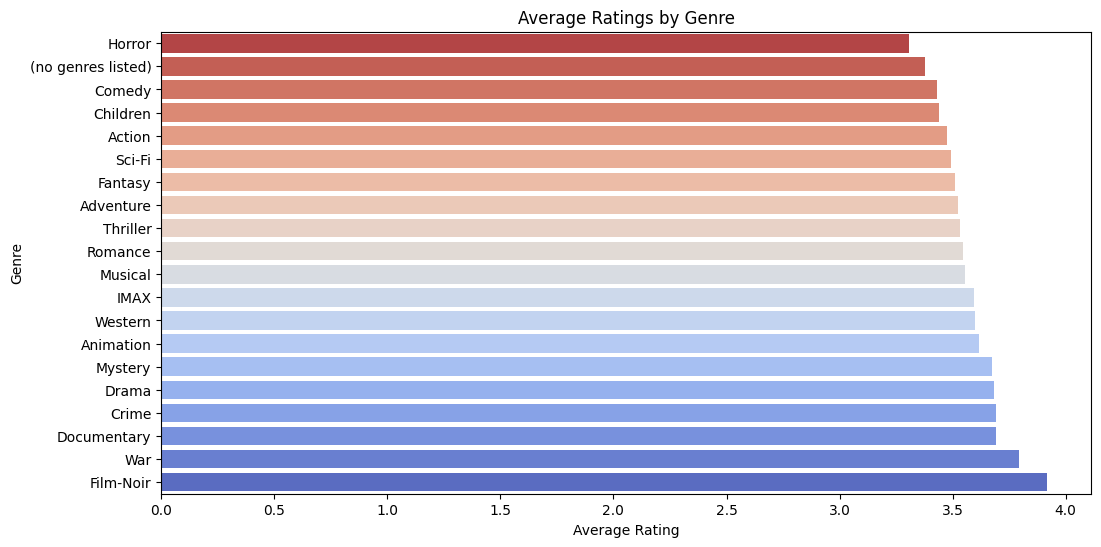

In [ ]:
# Expand movie-genre relationship
movies_expanded = movies.copy()
movies_expanded['genres'] = movies_expanded['genres'].str.split('|')
movies_expanded = movies_expanded.explode('genres')

# Merge with ratings
ratings_with_genres = ratings.merge(movies_expanded, on='movieId')

# Calculate average rating per genre
genre_avg_ratings = ratings_with_genres.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(y=genre_avg_ratings.index, x=genre_avg_ratings.values, palette="coolwarm")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.title("Average Ratings by Genre")
plt.gca().invert_yaxis()
plt.show()

<ipython-input-16-fbeb59fb9b68>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


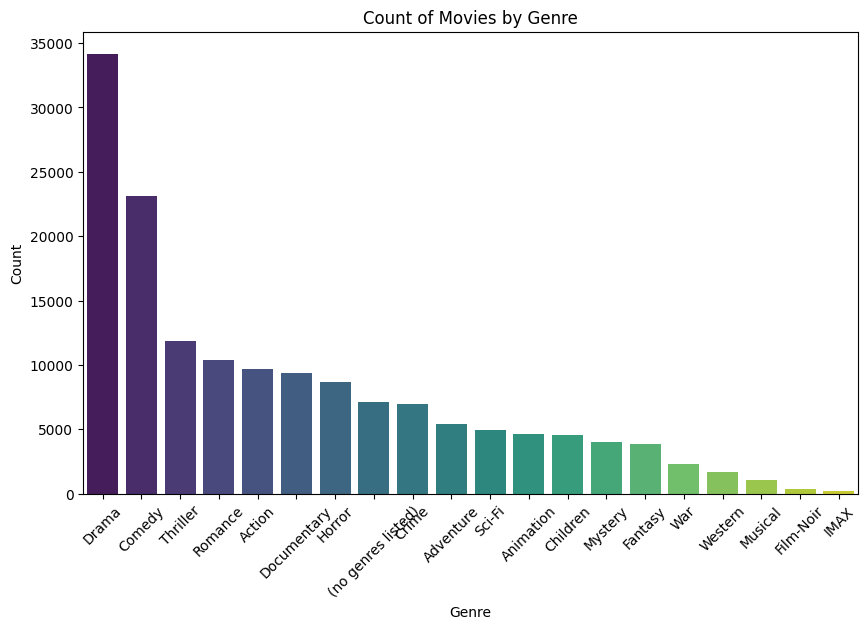

In [ ]:
# Since genres are pipe-separated, explode the genres into separate rows for counting
movies_genres = movies.copy()
movies_genres['genre'] = movies_genres['genres'].str.split('|')
movies_genres = movies_genres.explode('genre')

# Count of movies by genre
genre_counts = movies_genres['genre'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title("Count of Movies by Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Top 10 Genre Pairs:


,Pair,Count
11,"(Comedy, Drama)",6081
12,"(Drama, Romance)",5943
10,"(Comedy, Romance)",4602
26,"(Drama, Thriller)",4565
21,"(Crime, Drama)",3762
32,"(Horror, Thriller)",3042
23,"(Action, Drama)",3022
14,"(Action, Thriller)",2850
15,"(Crime, Thriller)",2747
16,"(Action, Adventure)",2100


<Figure size 1000x600 with 0 Axes>

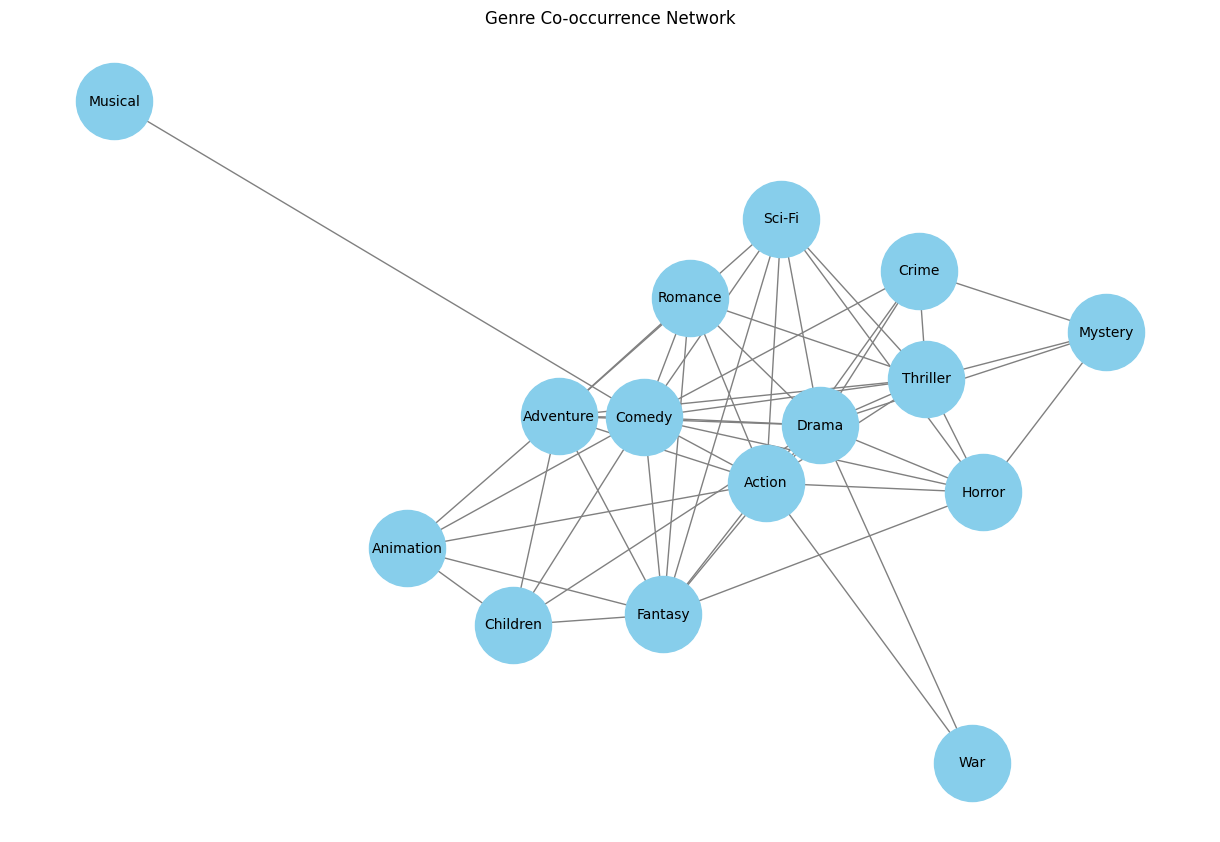

In [ ]:
from itertools import combinations
import networkx as nx
from collections import Counter

# Create genre pairs
genre_pairs = movies['genres'].dropna().str.split('|')
pair_counts = Counter()

for genres in genre_pairs:
    for pair in combinations(sorted(genres), 2):
        pair_counts[pair] += 1

# Convert to DataFrame
genre_pairs_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count'])
genre_pairs_df = genre_pairs_df.sort_values(by="Count", ascending=False).head(10)

# Display top genre co-occurrences
print("Top 10 Genre Pairs:")
display(genre_pairs_df)

# Plot co-occurrence network
plt.figure(figsize=(10,6))
G = nx.Graph()

for pair, count in pair_counts.items():
    if count > 500:  # Threshold for visualization
        G.add_edge(pair[0], pair[1], weight=count)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=3000, font_size=10)
plt.title("Genre Co-occurrence Network")
plt.show()

Tags Analysis

<ipython-input-18-cc2cae065198>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')


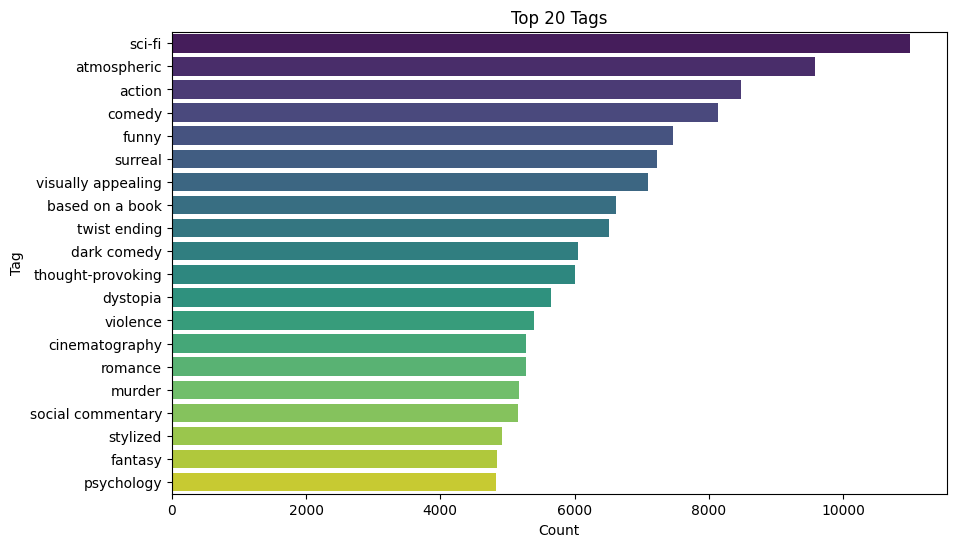

In [ ]:
# Tags Analysis

# Identify the most common tags
top_tags = tags['tag'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.values, y=top_tags.index, palette='viridis')
plt.title("Top 20 Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()

Temporal Analysis of Ratings

<ipython-input-19-f819d789b8ed>:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ratings_over_time = ratings.set_index('timestamp').resample('Y')['rating'].mean()


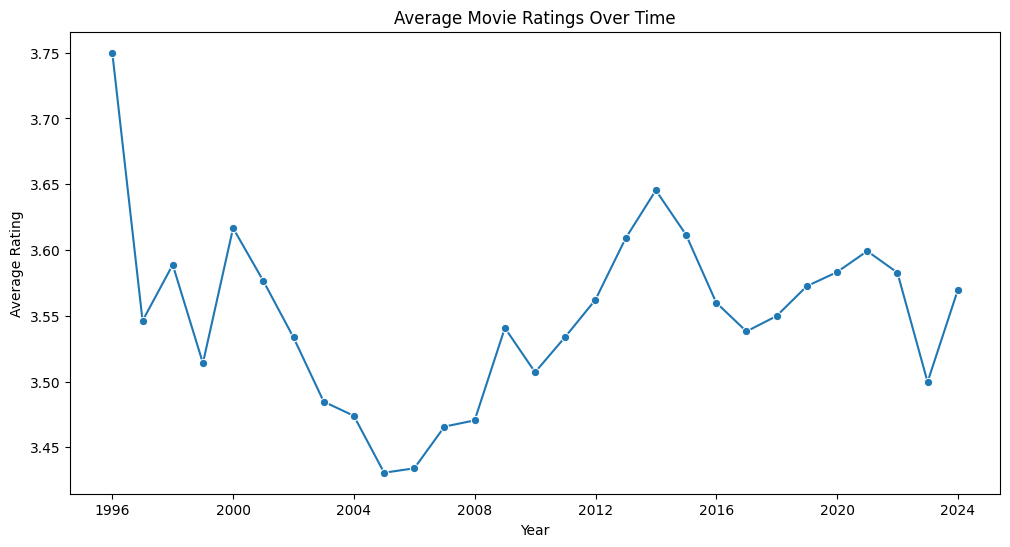

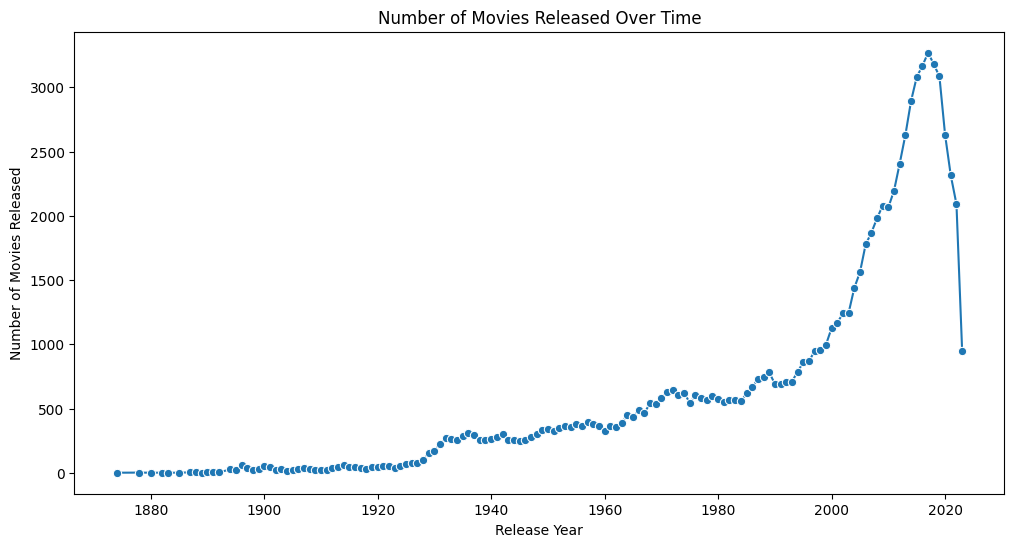

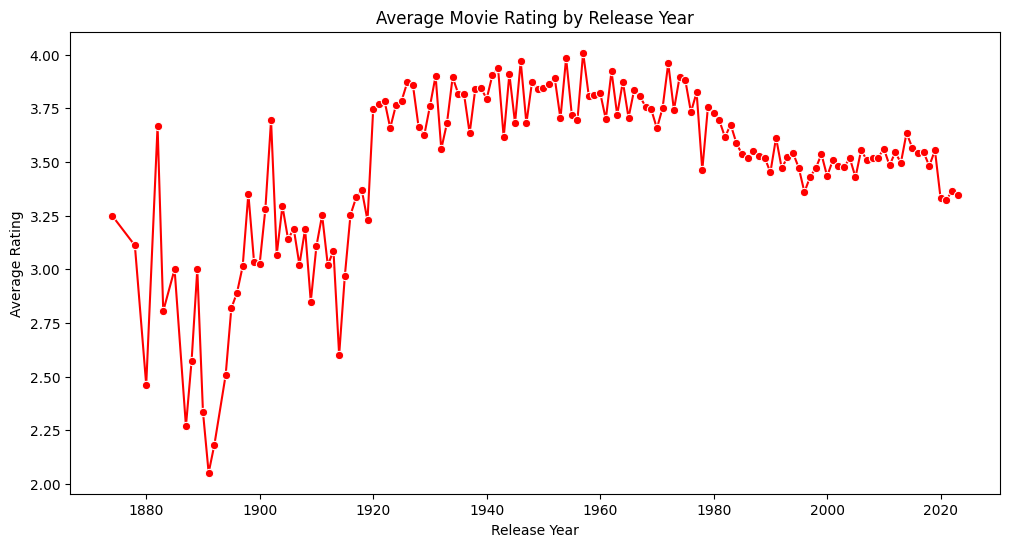

In [ ]:
# Group by year and calculate average rating
ratings_over_time = ratings.set_index('timestamp').resample('Y')['rating'].mean()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x=ratings_over_time.index, y=ratings_over_time.values, marker="o")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.title("Average Movie Ratings Over Time")
plt.show()

import re

# Extract release year from movie titles
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Count number of movies released per year
movies_per_year = movies['year'].value_counts().sort_index()

# Plot number of movies released per year
plt.figure(figsize=(12,6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker="o")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies Released")
plt.title("Number of Movies Released Over Time")
plt.show()

# Merge ratings with movie release years
ratings_with_year = ratings.merge(movies[['movieId', 'year']], on='movieId')

# Group by release year and calculate average rating
ratings_by_year = ratings_with_year.groupby('year')['rating'].mean()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values, marker="o", color="red")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.title("Average Movie Rating by Release Year")
plt.show()

Correlation Analysis

Correlation Matrix:


,avg_rating,num_ratings,year
avg_rating,1.00000,0.094690,-0.024990
num_ratings,0.09469,1.000000,-0.004695
year,-0.02499,-0.004695,1.000000


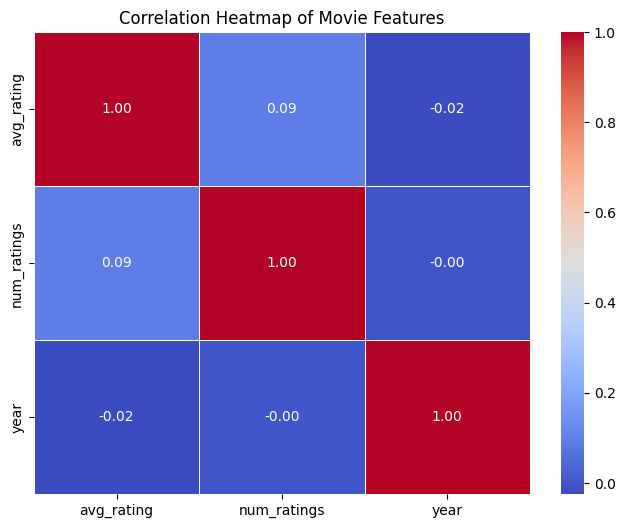

In [ ]:
# Calculate average rating per movie
movie_avg_ratings = ratings.groupby("movieId")["rating"].mean()

# Calculate number of ratings per movie
movie_rating_counts = ratings.groupby("movieId")["rating"].count()

# Merge with movie release year
movies_with_stats = movies[['movieId', 'year']].merge(
    pd.DataFrame(movie_avg_ratings).rename(columns={"rating": "avg_rating"}),
    on="movieId"
).merge(
    pd.DataFrame(movie_rating_counts).rename(columns={"rating": "num_ratings"}),
    on="movieId"
)

# Compute correlations
correlations = movies_with_stats[['avg_rating', 'num_ratings', 'year']].corr()

# Display correlation values
print("Correlation Matrix:")
display(correlations)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Movie Features")
plt.show()

Save Dataframe for next steps

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save DataFrames as CSV files to Google Drive
ratings.to_csv("/content/drive/MyDrive/ml-32m/EDA csvs/ratings.csv", index=False)
movies.to_csv("/content/drive/MyDrive/ml-32m/EDA csvs/movies.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/ml-32m/EDA pkls'

In [ ]:
tags.to_csv("/content/drive/MyDrive/ml-32m/EDA csvs/tags.csv", index=False)
links.to_csv("/content/drive/MyDrive/ml-32m/EDA csvs/links.csv", index=False)

print("DataFrames successfully saved to Google Drive as CSV files!")

DataFrames successfully saved to Google Drive as CSV files!
